## Diffusion form scratch in PyTorch and Lightning

No one have probably missed the recent boom and hype around Diffusion Models and their amazing results. Creating the most unimaginable images given a (the correct) text description. A couple of weeks ago Stability AI open sourced the powerful Stablediffusion model whom anyone can download and run. It is also fast enough to run locally on your own machine.

Now I have to admit that I have just barely scratched the surface of diffusion models and their details, I blame it on the impossible task of keeping up with high pace in the current machine learning community. So this post is about implementing a basic diffusion model in PyTorch and Lightning, train it on a dataset and at least touch on the details that make these model work. It will not be a dive to the depth of ocean, in those cases I will link to good resources that I have found useful for understanding the math and the derivation behind the equations. Lets start.

### Intro and High-level Intuition
So the basic idea of diffusion models is to learn a model that can create samples from some distribution, for example natural images, from noise. An analogy I like to have in mind is that the models are similar to a human forming a lump of clay into for example a cup, we start with something containing no information and slowly form something useful. 

The setup when training a diffusion model have two phases, a forward process, in which we over a set of timesteps $0:T$ add noise to an sample $\mathbf{x}_0$ so we end up with the sample at time $T$ only consisting of isotropic (uniform in all dimensions) gaussian noise with mean zero and variance one. Then we have a backward process where we do the opposite, go from the noisy sample $\mathbf{x}_T$ to the initial sample $\mathbf{x}_0$. It is this backward process we want to learn. The forward process is usually fixed and is just consisting of a noise scheduler which tells how much noise to add at each timestep. So, lets start with the forward process and take it from there.

#### Forward Diffusion Process

The noise is added by a variance schedule, $\{\beta\in(0,1)\}_{t=1}^{T}$. Lets create a function for that.

In [110]:
import torch

def linear_beta_schedule(timesteps: int, start: float = 0.0001, end: float = 0.02):
    """Creates a linear noise schedule"""
    return torch.linspace(start, end, timesteps)

Adding gaussian noise from one time step to the next is then defined by

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}\left(\mathbf{x}_t ; \sqrt{1 - \beta_t}\mathbf{x}_{t-1} , \beta_t\mathbf{I}\right)
$$

And the complete forward process can be written as

$$
q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) = \prod_{t=1}^{T}q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

If we then define a variable $\alpha_t \doteq 1 - \beta_t$ and use the fact that sampling from any normal distribution can be written as the mean plus the covariance times $\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$ (also known as the  reparameterization trick) we get that

$$
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 , (1 - \bar{\alpha_{t}})\mathbf{I})
\quad \Rightarrow \quad
\mathbf{x_t} = \sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha_{t}}}\epsilon
$$

Where $\bar{\alpha_t} = \prod_{i=0}^{t}\alpha_i$. So we see that we can sample $\mathbf{x_t}$ at any time $t$ given just $\mathbf{x}_0$, i.e we can sample in closed form. This is because a sums of gaussians is also gaussian. See [this excellent post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for derivation and details.

Our forward process function can then be implemented as

In [126]:
def get_val_from_t(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values 'vals' while considering the batch dimension
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    # reshape and 
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device="cpu"):
    """
    Takes an image 'x_0' and a time step 't' and returns the noisy version of the image at time 't'
    """
    noise = torch.randn_like(x_0).to(device)
    
    sqrt_alphas_cumprod_t = get_val_from_t(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_val_from_t(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)

    return (
        sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise,
        noise
        )

Note that we are using some variables here that we have not yet defined, these will be pre-calculated later. Otherwise that's it for the forward process! Now that we have it in place let us test it with some data.

### Dataset

We are going to use the Food-101 dataset and for our purpose we only need to know it is around a million images of food. Let us download it ( if you running this on your own machine keep in mind it is $\sim$ 5GB)

In [127]:
import torchvision

dataset = torchvision.datasets.Food101(root='data', download=True)

To get a feeling of the images we plot some examples

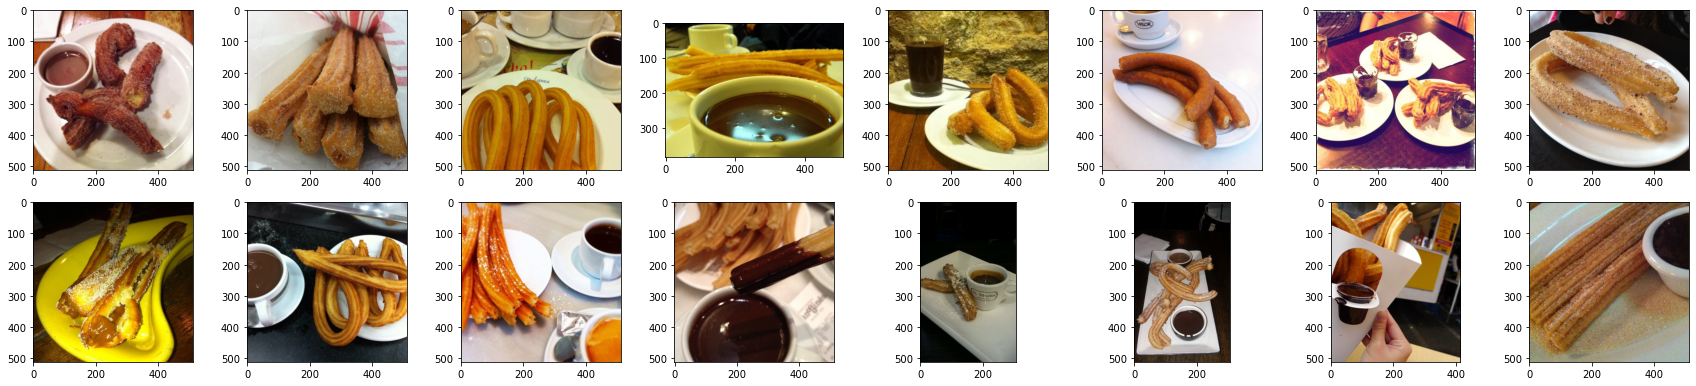

In [128]:
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=16, cols=8):
    """Plot some examples"""
    plt.figure(figsize=(30, 10))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])

show_images(dataset)
plt.show()

#### Transform the data

The images are in PIL format and we need them as pytorch tensors. Here we transform them and also put them into a DataLoader that will be used at training.

In [129]:
from torchvision import transforms 
from torch.utils.data import DataLoader

IMG_SIZE = 64
BATCH_SIZE = 128

dataset_transformed = torchvision.datasets.Food101(root='data', transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # convert values to be between [-1.0,  1.0]
    transforms.Lambda(lambda x: (x * 2) - 1)
]))

# dimensions will be (batch, C, H, W)
dataloader = DataLoader(dataset_transformed, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Now we get to those pre-calculated values I mentioned before. Some values will be the same for all $t$ like $\sqrt{\bar{\alpha_{t}}}$ and $\sqrt{1 - \bar{\alpha_{t}}}$. So instead of calculate them every time we want to get a sample $\mathbf{x}_t$ we do it once in the beginning.

In [130]:
# Number of time steps
T = 300

# Create the betas
betas = linear_beta_schedule(timesteps=T)

# Pre-calculations
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Now we are ready to test our forward diffusion process

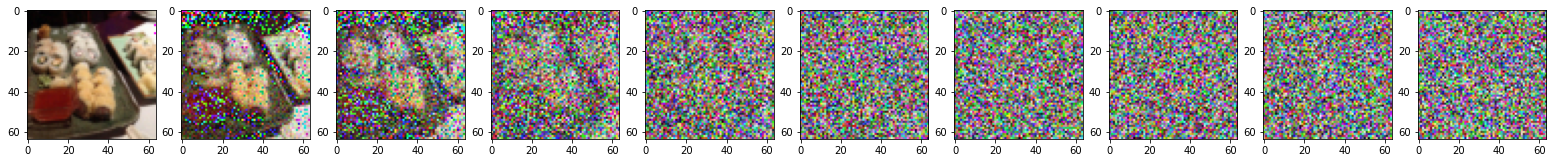

In [131]:
import numpy as np

def show_tensor_image(image):
    """Reverse the transformation and plot the image"""
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# take an image
image_0 = next(iter(dl))[0]

# since plotting 'T' number of images is a bit much we decrease it
num_images = 10
stepsize = T // num_images

plt.figure(figsize=(30, 30))
plt.axis('off')
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, idx // stepsize + 1)
    image_t, _ = forward_diffusion(image_0, t)
    show_tensor_image(image_t)

Seems to work quite well. Just to confirm we can check that the last image indeed is similar to noise drawn from $\sim \mathcal{N}(0, \mathbf{I})$

In [132]:
torch.std_mean(image_t)

(tensor(0.9713), tensor(-0.0367))

Quite close, you an try and change $T$ and as you increase it we will get closer to the wanted distribution.

### Reverse diffusion process

So how do we go back? From noise to the original image? It might at first feel trivial since it was so easy to arrive at the noisy version. But remember, at each step when adding noise we lose information in a statistical fashion. In other words, we create an extremely large amount of possible ways to go back. In fact, to reverse the process and get back the original distribution we would have to integrate (marginalize) over all possible ways we could arrive at the original image $\mathbf{x_0}$ including all the latent (non observed) variables on the way. This is understandably intractable in the case of natural images. So the only way we could manage this is by approximation!

Here comes neural networks, once again, to the rescue. So, the idea is to train a neural network parameterized by $\theta$ to approximate

$$ q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t}) \approx p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$$

The first obvious way to do this would be to estimate the mean and covariance for each denoising step.

$$p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mu_{\theta}(\mathbf{x}_t, t), \Sigma_{\theta}(\mathbf{x}_t, t))$$

However the authors of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239v2.pdf) paper explored an alterative parameterization. Instead of estimating the mean we can make the network estimate the noise added at each time step, $\epsilon_{\theta}(\mathbf{x}_t, t)$. This since it can be shown that (jump into the paper for the derivation)

$$ \mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(\mathbf{x}_t, t) \right)$$

This makes it possible to simplify the variational lower bound while maintaining performance, sounds a bit scary but let's leave it there for now.

### Network Architecture

We will use the same architecture as [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239v2.pdf) which is basically a U-Net with Attention and the network will predict the noise added between two steps, $\epsilon_{\theta}(\mathbf{x}_t, t)$

In [133]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print(f"Num params: {sum(p.numel() for p in model.parameters()):,}")
       

Num params: 62,438,883


In [134]:
import torch.nn.functional as F

def get_loss(model, x_0, t, device):
    x_noisy, noise = forward_diffusion(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [139]:
@torch.no_grad()
def sample_timestep(x, t, device):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_val_from_t(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_val_from_t(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_val_from_t(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_val_from_t(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(device):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, device=device)
        if i % stepsize == 0:
            plt.subplot(1, num_images, num_images - (i // stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()

epoch:    0 | step 000
Epoch 0 | step 000 Loss: 0.708096981048584 


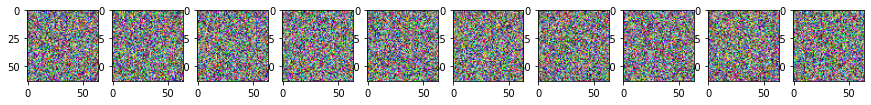

epoch:    0 | step 001
epoch:    0 | step 002
epoch:    0 | step 003
epoch:    0 | step 004


In [140]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      print(f"epoch: {epoch:4} | step {step:03d}")
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t, device=device)
      loss.backward()
      optimizer.step()
      
      if epoch % 5 == 0 and step == 0:
        sample_plot_image(device=device)

In [98]:
from functools import partial
import math
from tokenize import group

from torch import nn
from einops import reduce, rearrange

class UNet(nn.Module):
    def __init__(self, in_ch: int, init_dim: int, time_emb_dim: int, num_res: int = 4):
        super().__init__()
        
        # initial conv
        self.init_conv = nn.Conv2d(in_ch, init_dim, kernel_size=7, padding=3)
        
        # dimensions
        dims = [init_dim, *map(lambda m: init_dim * m, [2**res for res in range(0, num_res)])]
        print(dims)
        in_out_dims = list(zip(dims[:-1], dims[1:]))
        print(in_out_dims)
        
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(),
            nn.Linear(init_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # downsample
        self.down_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out_dims):
            is_last = ind >= num_res
            
            self.down_layers.append(nn.ModuleList([
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))
        
        # middle block
        mid_dim = dims[-1]
        self.mid_block1 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        
        # upsample
        self.up_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out_dims)):
            is_last = ind >= num_res
            
            self.up_layers.append(nn.ModuleList([
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))
        
        self.final_res_block = ResNetBlock(dim * 2, dim, time_emb_dim = time_emb_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)
    
    def forward(self, x, t):
        return self.init_conv(x)

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class ResNetBlock(nn.Module):
    def __init__(self, dim, dim_in, dim_out, time_emb_dim = None, groups = 8):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if time_emb_dim is not None else None
        
        self.block1 = Block(dim, dim_out, groups=group)
        self.block2 = Block(dim_out, dim_out, groups=group)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
    
    def forward(self, x, t, time_emb = None):
        
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
        
        
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x
        

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g
    
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)
        

In [99]:
test_data = torch.randn((128, 3, 64, 64))
model = UNet(in_ch=3, init_dim=64, time_emb_dim=32)
out = model(test_data, 0)
print(out.shape)

[64, 64, 128, 256, 512]
[(64, 64), (64, 128), (128, 256), (256, 512)]


TypeError: __init__() missing 1 required positional argument: 'dim'

# Loss

# Training

# Results and Samples

# Conclusions